# Climate and vegetation

- Variables are: `NDVI_mm`, `SWVL1_mm`, `STL1_mm`, `WB_mm`, `WD_mm`, `TP_mm`, `E_mm`, `RELHUM_mm`, `SSR_mm`, and `T2M_mm`.
- `Mutual information` between vegetation and climate variables with and without lags.
- Without lags.

## 1 Initial setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Load packages.
import sys
import glob

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from cartopy import crs as ccrs
from cartopy import feature as cfeature
from cartopy.io import shapereader
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mpl_toolkits.axes_grid1 import AxesGrid

%matplotlib inline

In [4]:
# First we will use cartopy's shapereader to download (and cache) 
# states shapefile with 50 meters resolution from the NaturalEarth.
kw = dict(
    resolution="50m", 
    category="cultural", 
    name="admin_1_states_provinces"
)
states_shp = shapereader.natural_earth(**kw)
shp = shapereader.Reader(states_shp)

In [5]:
print(">>> Version of xarray:", xr.__version__)

>>> Version of xarray: 0.14.0


In [6]:
# My repository.
repository = "/home/alex/Dropbox/repositories/"

# Include once my repository in the path for searching libraries.
if repository not in sys.path:
    sys.path.append(repository)
    
# Import my package.
import cdlearn

# Map borders.
loni, lonf, lati, latf = -90, -30, -60, 20

# Time range. The same as GIMMS ndvi.
ti, tf = "1981-07", "2015-12"

# Where figures will be put.
fig_path = "/home/alex/Dropbox/repositories/phd/images/"

## 2 Load monthly data

In [7]:
%%time

# Monthly means (mm).
var_labels = [
    "NDVI_mm", 
    "SWVL1_mm", 
    "STL1_mm", 
    "WB_mm",
    "WD_mm",
    "TP_mm", 
    "E_mm", 
    "RELHUM_mm", 
    "SSR_mm", 
    "T2M_mm"
]

codes = [
    "ndvi", 
    "swvl1", 
    "stl1", 
    "wb",
    "wd",
    "tp", 
    "e", 
    "relhum", 
    "ssr", 
    "t2m"
]

# South America.
region = {
    "loni": loni, 
    "lonf": lonf, 
    "lati": lati, 
    "latf": latf
}

# The same as GIMMS ndvi.
time_range = {
    "ti": ti, 
    "tf": tf
}

verbose = False
cd = cdlearn.pixels.ClimateData(
    var_labels=var_labels, 
    region=region,
    time_range=time_range,
    verbose=verbose
)

CPU times: user 10.6 s, sys: 187 ms, total: 10.8 s
Wall time: 10.9 s


**DANGER ZONE! Memory intensive operation**

In [8]:
%%time

DSs = cd.load_into_memory(verbose=verbose)

CPU times: user 26.2 s, sys: 2.41 s, total: 28.6 s
Wall time: 26.1 s


## 3 Mutual information between variables (monthly data)

In [9]:
%%time

print("\n>>> Mutual information between vegetation and climate (scaled data):")
mis = []
for index, DS in enumerate(DSs.values()):
    
    if index > 0: 
        
        # Select variables.
        da1 = DSs["NDVI_mm"].ndvi  # Always ndvi.  
        da2 = getattr(DS, codes[index])

        # Scale data.
        da1_scaled = (
            (da1 - da1.mean("time", skipna=True)) / da1.std("time", skipna=True)
        ).fillna(value=0)
        da2_scaled = (
            (da2 - da2.mean("time", skipna=True)) / da2.std("time", skipna=True)
        ).fillna(value=0)

        print("* Calculating", "ndvi x", codes[index], "...")
    
        # Nonlinear relationship.
        mi = cdlearn.information_theory.mutual_information_map(
            da1_scaled, da2_scaled, lag=0, normalize=False
        )

        # Put mask.
        mi = cdlearn.pixels.EraInterimGrid.add_land_mask(mi)
    
        # Add to list of results.
        mis.append(mi)


>>> Mutual information between vegetation and climate (scaled data):
* Calculating ndvi x swvl1 ...
* Calculating ndvi x stl1 ...
* Calculating ndvi x wb ...
* Calculating ndvi x wd ...
* Calculating ndvi x tp ...
* Calculating ndvi x e ...
* Calculating ndvi x relhum ...
* Calculating ndvi x ssr ...
* Calculating ndvi x t2m ...
CPU times: user 1min 46s, sys: 243 ms, total: 1min 46s
Wall time: 1min 46s


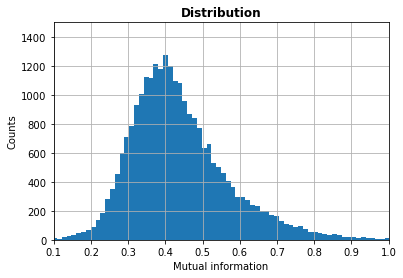

In [10]:
# Distribution of values.
d = []
D = [d.append(mi.values) for mi in mis]
d = np.array(d).reshape((-1))
d = d[np.isfinite(d)]
plt.hist(d, bins=100)
plt.xlabel("Mutual information")
plt.ylabel("Counts")
plt.title("Distribution", weight="bold")
plt.xlim((0.1, 1.0))
plt.ylim((0.0, 1500))
plt.grid();

CPU times: user 643 ms, sys: 3.97 ms, total: 647 ms
Wall time: 645 ms


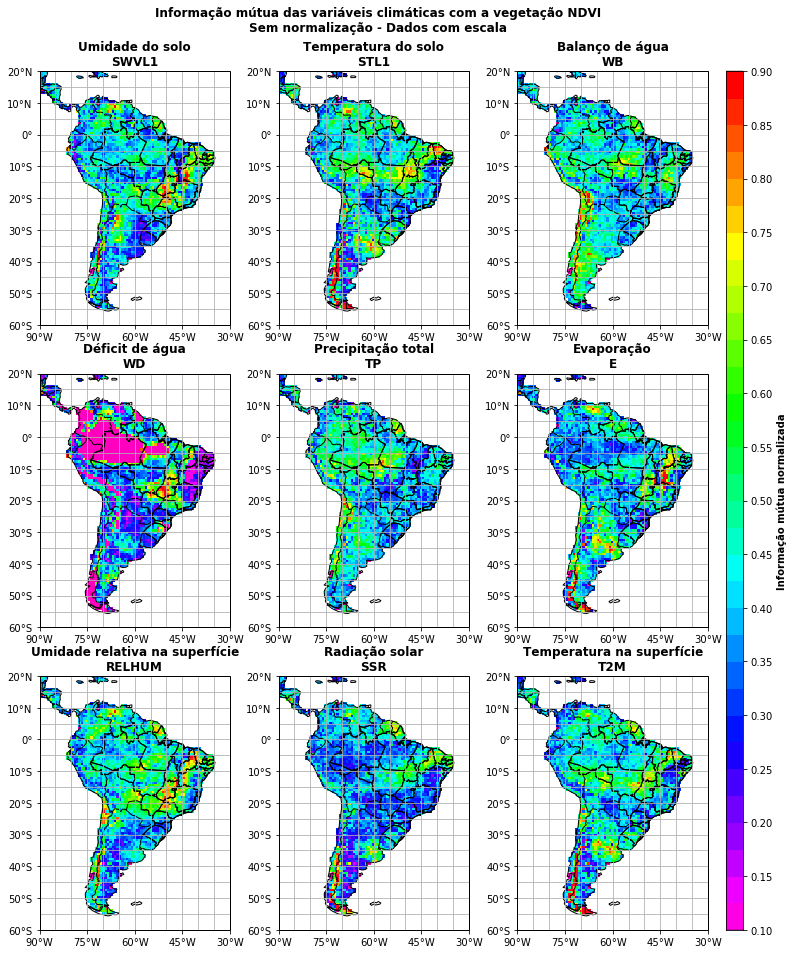

In [11]:
%%time

titles = [
    "Umidade do solo\n" + codes[1].upper(),
    "Temperatura do solo\n" + codes[2].upper(),
    "Balanço de água\n" + codes[3].upper(),
    "Déficit de água\n" + codes[4].upper(),
    "Precipitação total\n" + codes[5].upper(),
    "Evaporação\n" + codes[6].upper(),
    "Umidade relativa na superfície\n" + codes[7].upper(),
    "Radiação solar\n" + codes[8].upper(),
    "Temperatura na superfície\n" + codes[9].upper()
]

# Make grid object.
projection = ccrs.PlateCarree()
axes_class = (GeoAxes, dict(map_projection=projection))
fig = plt.figure(figsize=(15, 15))

axgr = AxesGrid(
    fig=fig, 
    rect=111, 
    axes_class=axes_class,
    nrows_ncols=(3, 3),
    axes_pad=0.675,
    cbar_location="right",
    cbar_mode="single",
    cbar_pad=0.25,
    cbar_size="3%",
    label_mode=""
)

# Make maps.
for index, axis in enumerate(axgr):
    axis.coastlines()
    axis.set_extent([loni, lonf, latf, lati], crs=projection)
    axis.add_feature(cfeature.BORDERS)
    axis.set_xticks(np.arange(-90, -15, 15), crs=projection)
    axis.set_yticks(np.arange(-60, 30, 10), crs=projection)
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    axis.xaxis.set_major_formatter(lon_formatter)
    axis.yaxis.set_major_formatter(lat_formatter)
    axis.gridlines(xlocs=range(-90, -25, 5), ylocs=range(-60, 25, 5))        
   
    # Plot data on these maps.
    p = mis[index].where(mis[index].land_mask == True).plot(
        ax=axis,
        vmin=0.1,
        vmax=0.9,
        levels=np.arange(0.1, 0.925, 0.025),
        cmap=plt.cm.gist_rainbow_r,
        add_colorbar=False,
        add_labels=False
    )

    axis.set_title(titles[index], weight="bold")
    
    # Brazilian states's boundaries.
    for state in shp.geometries():
        axis.add_geometries(
            geoms=[state], 
            crs=projection, 
            facecolor="none", 
            edgecolor="black"
        )    
        
# Fill common colorbar.        
cb = axgr.cbar_axes[0].colorbar(p)
cb.set_label_text("Informação mútua normalizada", weight="bold")
cb.cbar_axis.set_ticks(np.arange(0.1, 0.95, 0.05))        
plt.suptitle("Informação mútua das variáveis climáticas com a vegetação NDVI\n" + \
             "Sem normalização - Dados com escala", 
             weight="bold")
plt.subplots_adjust(top=0.92)

In [12]:
%%time

print("\n>>> Mutual information between vegetation and climate (unscaled data):")
mis = []
for index, DS in enumerate(DSs.values()):
    
    if index > 0: 
        
        # Select variables.
        da1 = DSs["NDVI_mm"].ndvi  # Always ndvi.  
        da2 = getattr(DS, codes[index])

        print("* Calculating", "ndvi x", codes[index], "...")
    
        # Nonlinear relationship.
        mi = cdlearn.information_theory.mutual_information_map(
            da1, da2, lag=0, normalize=False
        )

        # Put mask.
        mi = cdlearn.pixels.EraInterimGrid.add_land_mask(mi)
    
        # Add to list of results.
        mis.append(mi)


>>> Mutual information between vegetation and climate (unscaled data):
* Calculating ndvi x swvl1 ...
* Calculating ndvi x stl1 ...
* Calculating ndvi x wb ...
* Calculating ndvi x wd ...
* Calculating ndvi x tp ...
* Calculating ndvi x e ...
* Calculating ndvi x relhum ...
* Calculating ndvi x ssr ...
* Calculating ndvi x t2m ...
CPU times: user 1min 49s, sys: 307 ms, total: 1min 50s
Wall time: 1min 50s


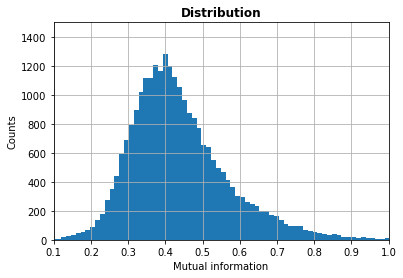

In [13]:
# Distribution of values.
d = []
D = [d.append(mi.values) for mi in mis]
d = np.array(d).reshape((-1))
d = d[np.isfinite(d)]
plt.hist(d, bins=100)
plt.xlabel("Mutual information")
plt.ylabel("Counts")
plt.title("Distribution", weight="bold")
plt.xlim((0.1, 1.0))
plt.ylim((0.0, 1500))
plt.grid();

CPU times: user 909 ms, sys: 12 ms, total: 921 ms
Wall time: 981 ms


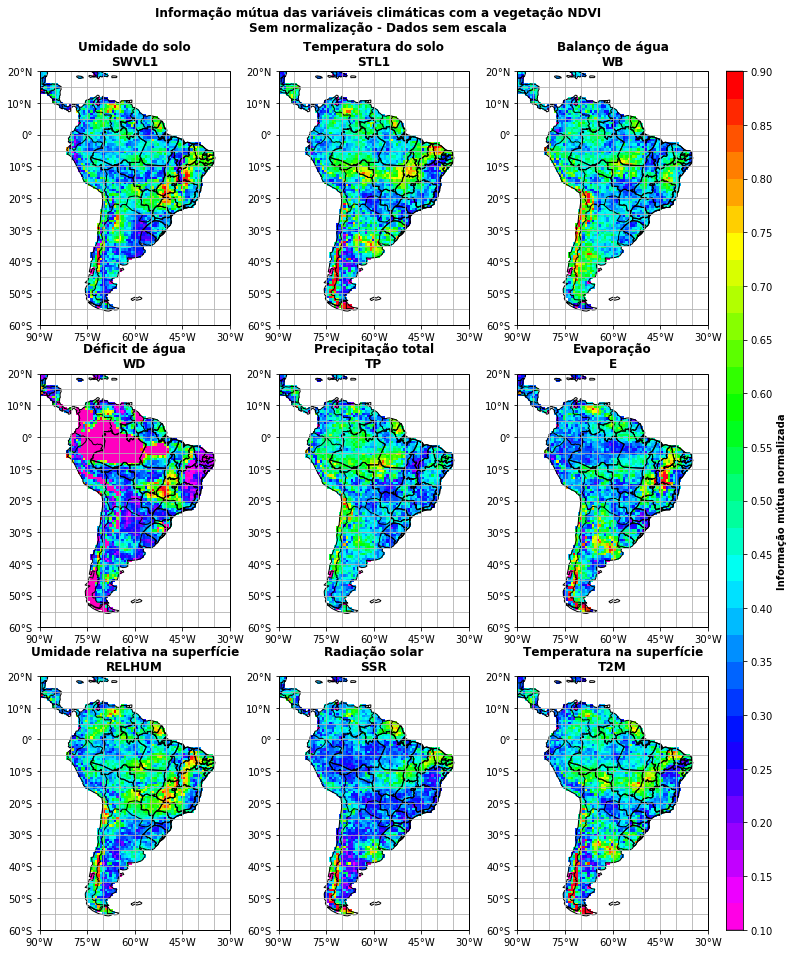

In [14]:
%%time

titles = [
    "Umidade do solo\n" + codes[1].upper(),
    "Temperatura do solo\n" + codes[2].upper(),
    "Balanço de água\n" + codes[3].upper(),
    "Déficit de água\n" + codes[4].upper(),
    "Precipitação total\n" + codes[5].upper(),
    "Evaporação\n" + codes[6].upper(),
    "Umidade relativa na superfície\n" + codes[7].upper(),
    "Radiação solar\n" + codes[8].upper(),
    "Temperatura na superfície\n" + codes[9].upper()
]

# Make grid object.
projection = ccrs.PlateCarree()
axes_class = (GeoAxes, dict(map_projection=projection))
fig = plt.figure(figsize=(15, 15))

axgr = AxesGrid(
    fig=fig, 
    rect=111, 
    axes_class=axes_class,
    nrows_ncols=(3, 3),
    axes_pad=0.675,
    cbar_location="right",
    cbar_mode="single",
    cbar_pad=0.25,
    cbar_size="3%",
    label_mode=""
)

# Make maps.
for index, axis in enumerate(axgr):
    axis.coastlines()
    axis.set_extent([loni, lonf, latf, lati], crs=projection)
    axis.add_feature(cfeature.BORDERS)
    axis.set_xticks(np.arange(-90, -15, 15), crs=projection)
    axis.set_yticks(np.arange(-60, 30, 10), crs=projection)
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    axis.xaxis.set_major_formatter(lon_formatter)
    axis.yaxis.set_major_formatter(lat_formatter)
    axis.gridlines(xlocs=range(-90, -25, 5), ylocs=range(-60, 25, 5))        
   
    # Plot data on these maps.
    p = mis[index].where(mis[index].land_mask == True).plot(
        ax=axis,
        vmin=0.1,
        vmax=0.9,
        levels=np.arange(0.1, 0.925, 0.025),
        cmap=plt.cm.gist_rainbow_r,
        add_colorbar=False,
        add_labels=False
    )

    axis.set_title(titles[index], weight="bold")
    
    # Brazilian states's boundaries.
    for state in shp.geometries():
        axis.add_geometries(
            geoms=[state], 
            crs=projection, 
            facecolor="none", 
            edgecolor="black"
        )    
        
# Fill common colorbar.        
cb = axgr.cbar_axes[0].colorbar(p)
cb.set_label_text("Informação mútua normalizada", weight="bold")
cb.cbar_axis.set_ticks(np.arange(0.1, 0.95, 0.05))        
plt.suptitle("Informação mútua das variáveis climáticas com a vegetação NDVI\n" + \
             "Sem normalização - Dados sem escala", 
             weight="bold")
plt.subplots_adjust(top=0.92)    

In [15]:
%%time

print("\n>>> Normalized mutual information between vegetation and climate (scaled data):")
mis = []
for index, DS in enumerate(DSs.values()):
    
    if index > 0: 
        
        # Select variables.
        da1 = DSs["NDVI_mm"].ndvi  # Always ndvi.  
        da2 = getattr(DS, codes[index])

        # Scale data.
        da1_scaled = (
            (da1 - da1.mean("time", skipna=True)) / da1.std("time", skipna=True)
        ).fillna(value=0)
        da2_scaled = (
            (da2 - da2.mean("time", skipna=True)) / da2.std("time", skipna=True)
        ).fillna(value=0)

        print("* Calculating", "ndvi x", codes[index], "...")
    
        # Nonlinear relationship.
        mi = cdlearn.information_theory.mutual_information_map(
            da1_scaled, da2_scaled, lag=0, normalize=True
        )

        # Put mask.
        mi = cdlearn.pixels.EraInterimGrid.add_land_mask(mi)
    
        # Add to list of results.
        mis.append(mi)


>>> Normalized mutual information between vegetation and climate (scaled data):
* Calculating ndvi x swvl1 ...
* Calculating ndvi x stl1 ...
* Calculating ndvi x wb ...
* Calculating ndvi x wd ...
* Calculating ndvi x tp ...
* Calculating ndvi x e ...
* Calculating ndvi x relhum ...
* Calculating ndvi x ssr ...
* Calculating ndvi x t2m ...
CPU times: user 1min 51s, sys: 299 ms, total: 1min 52s
Wall time: 1min 52s


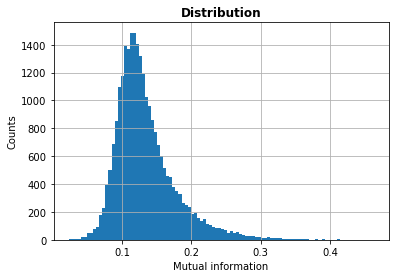

In [16]:
# Distribution of values.
d = []
D = [d.append(mi.values) for mi in mis]
d = np.array(d).reshape((-1))
d = d[np.isfinite(d)]
plt.hist(d, bins=100)
plt.xlabel("Mutual information")
plt.ylabel("Counts")
plt.title("Distribution", weight="bold")
plt.grid();

CPU times: user 691 ms, sys: 0 ns, total: 691 ms
Wall time: 690 ms


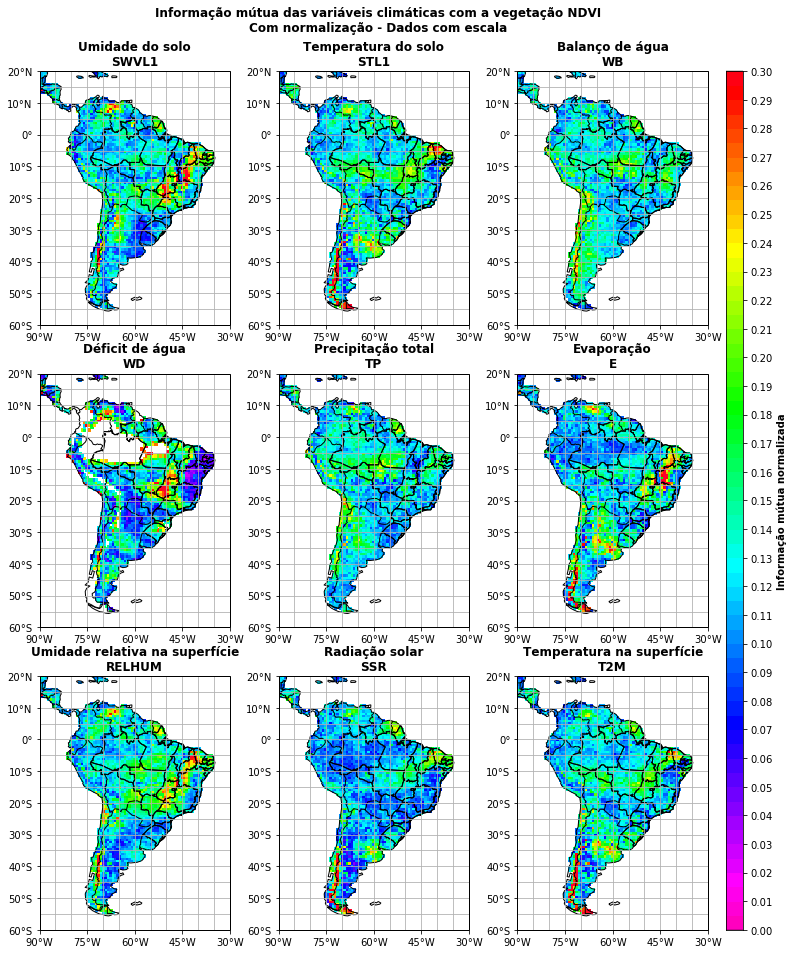

In [17]:
%%time

titles = [
    "Umidade do solo\n" + codes[1].upper(),
    "Temperatura do solo\n" + codes[2].upper(),
    "Balanço de água\n" + codes[3].upper(),
    "Déficit de água\n" + codes[4].upper(),
    "Precipitação total\n" + codes[5].upper(),
    "Evaporação\n" + codes[6].upper(),
    "Umidade relativa na superfície\n" + codes[7].upper(),
    "Radiação solar\n" + codes[8].upper(),
    "Temperatura na superfície\n" + codes[9].upper()
]

# Make grid object.
projection = ccrs.PlateCarree()
axes_class = (GeoAxes, dict(map_projection=projection))
fig = plt.figure(figsize=(15, 15))

axgr = AxesGrid(
    fig=fig, 
    rect=111, 
    axes_class=axes_class,
    nrows_ncols=(3, 3),
    axes_pad=0.675,
    cbar_location="right",
    cbar_mode="single",
    cbar_pad=0.25,
    cbar_size="3%",
    label_mode=""
)

# Make maps.
for index, axis in enumerate(axgr):
    axis.coastlines()
    axis.set_extent([loni, lonf, latf, lati], crs=projection)
    axis.add_feature(cfeature.BORDERS)
    axis.set_xticks(np.arange(-90, -15, 15), crs=projection)
    axis.set_yticks(np.arange(-60, 30, 10), crs=projection)
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    axis.xaxis.set_major_formatter(lon_formatter)
    axis.yaxis.set_major_formatter(lat_formatter)
    axis.gridlines(xlocs=range(-90, -25, 5), ylocs=range(-60, 25, 5))        
   
    # Plot data on these maps.
    p = mis[index].where(mis[index].land_mask == True).plot(
        ax=axis,
        vmin=0.0,
        vmax=0.3,
        levels=np.arange(0.0, 0.303, 0.005),
        cmap=plt.cm.gist_rainbow_r,
        add_colorbar=False,
        add_labels=False
    )

    axis.set_title(titles[index], weight="bold")
    
    # Brazilian states's boundaries.
    for state in shp.geometries():
        axis.add_geometries(
            geoms=[state], 
            crs=projection, 
            facecolor="none", 
            edgecolor="black"
        )    
        
# Fill common colorbar.        
cb = axgr.cbar_axes[0].colorbar(p)
cb.set_label_text("Informação mútua normalizada", weight="bold")
cb.cbar_axis.set_ticks(np.arange(0.0, 0.31, 0.01))        
plt.suptitle("Informação mútua das variáveis climáticas com a vegetação NDVI\n" + \
             "Com normalização - Dados com escala", 
             weight="bold")
plt.subplots_adjust(top=0.92)

In [18]:
%%time

print("\n>>> Normalized mutual information between vegetation and climate (unscaled data):")
mis = []
for index, DS in enumerate(DSs.values()):
    
    if index > 0: 
        
        # Select variables.
        da1 = DSs["NDVI_mm"].ndvi  # Always ndvi.  
        da2 = getattr(DS, codes[index])

        print("* Calculating", "ndvi x", codes[index], "...")
    
        # Nonlinear relationship.
        mi = cdlearn.information_theory.mutual_information_map(
            da1, da2, lag=0, normalize=True
        )

        # Put mask.
        mi = cdlearn.pixels.EraInterimGrid.add_land_mask(mi)
    
        # Add to list of results.
        mis.append(mi)


>>> Normalized mutual information between vegetation and climate (unscaled data):
* Calculating ndvi x swvl1 ...
* Calculating ndvi x stl1 ...
* Calculating ndvi x wb ...
* Calculating ndvi x wd ...
* Calculating ndvi x tp ...
* Calculating ndvi x e ...
* Calculating ndvi x relhum ...
* Calculating ndvi x ssr ...
* Calculating ndvi x t2m ...
CPU times: user 1min 46s, sys: 128 ms, total: 1min 46s
Wall time: 1min 47s


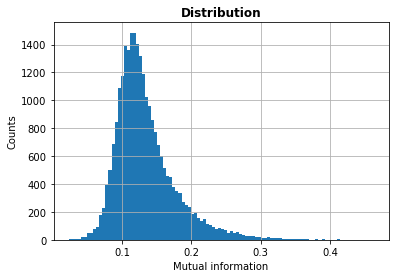

In [19]:
# Distribution of values.
d = []
D = [d.append(mi.values) for mi in mis]
d = np.array(d).reshape((-1))
d = d[np.isfinite(d)]
plt.hist(d, bins=100)
plt.xlabel("Mutual information")
plt.ylabel("Counts")
plt.title("Distribution", weight="bold")
plt.grid();

CPU times: user 5.2 s, sys: 941 ms, total: 6.14 s
Wall time: 4.37 s


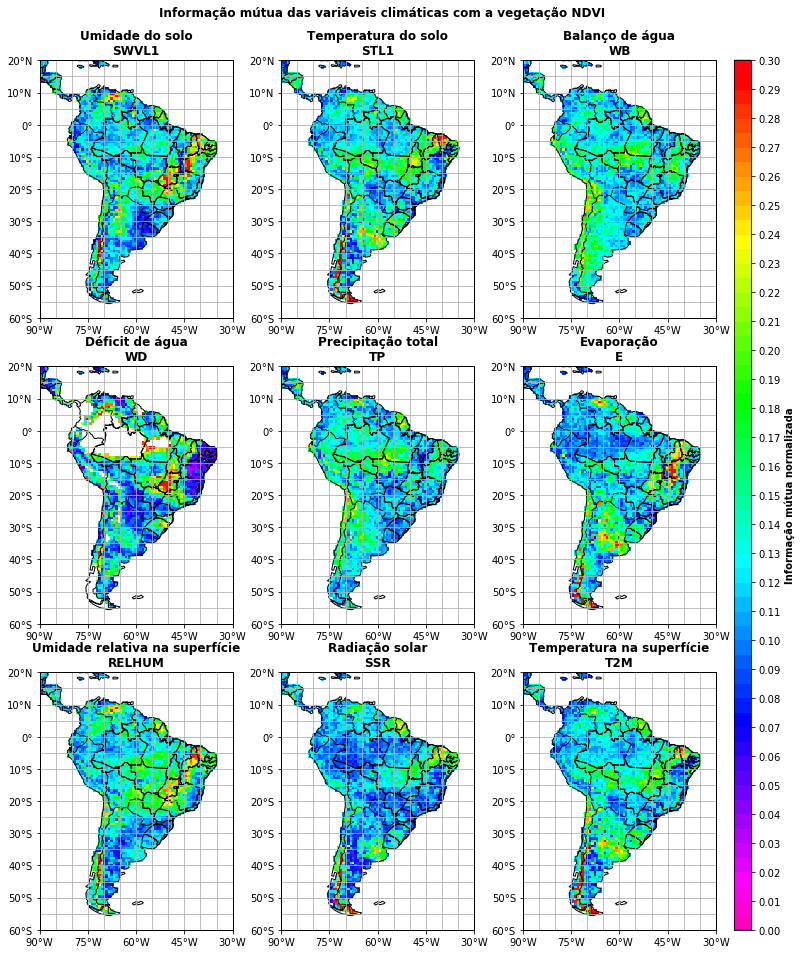

In [20]:
%%time

titles = [
    "Umidade do solo\n" + codes[1].upper(),
    "Temperatura do solo\n" + codes[2].upper(),
    "Balanço de água\n" + codes[3].upper(),
    "Déficit de água\n" + codes[4].upper(),
    "Precipitação total\n" + codes[5].upper(),
    "Evaporação\n" + codes[6].upper(),
    "Umidade relativa na superfície\n" + codes[7].upper(),
    "Radiação solar\n" + codes[8].upper(),
    "Temperatura na superfície\n" + codes[9].upper()
]

# Make grid object.
projection = ccrs.PlateCarree()
axes_class = (GeoAxes, dict(map_projection=projection))
fig = plt.figure(figsize=(15, 15))

axgr = AxesGrid(
    fig=fig, 
    rect=111, 
    axes_class=axes_class,
    nrows_ncols=(3, 3),
    axes_pad=0.675,
    cbar_location="right",
    cbar_mode="single",
    cbar_pad=0.25,
    cbar_size="3%",
    label_mode=""
)

# Make maps.
for index, axis in enumerate(axgr):
    axis.coastlines()
    axis.set_extent([loni, lonf, latf, lati], crs=projection)
    axis.add_feature(cfeature.BORDERS)
    axis.set_xticks(np.arange(-90, -15, 15), crs=projection)
    axis.set_yticks(np.arange(-60, 30, 10), crs=projection)
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    axis.xaxis.set_major_formatter(lon_formatter)
    axis.yaxis.set_major_formatter(lat_formatter)
    axis.gridlines(xlocs=range(-90, -25, 5), ylocs=range(-60, 25, 5))        
   
    # Plot data on these maps.
    p = mis[index].where(mis[index].land_mask == True).plot(
        ax=axis,
        vmin=0.0,
        vmax=0.3,
        levels=np.arange(0.0, 0.303, 0.005),
        cmap=plt.cm.gist_rainbow_r,
        add_colorbar=False,
        add_labels=False
    )

    axis.set_title(titles[index], weight="bold")
    
    # Brazilian states's boundaries.
    for state in shp.geometries():
        axis.add_geometries(
            geoms=[state], 
            crs=projection, 
            facecolor="none", 
            edgecolor="black"
        )    
        
# Fill common colorbar.        
cb = axgr.cbar_axes[0].colorbar(p)
cb.set_label_text("Informação mútua normalizada", weight="bold")
cb.cbar_axis.set_ticks(np.arange(0.0, 0.31, 0.01))           
plt.suptitle("Informação mútua das variáveis climáticas com a vegetação NDVI", weight="bold")
plt.subplots_adjust(top=0.93)    

# Save figures.
plt.savefig(fig_path + "ndvi_climate_mutual_information_pt.jpg", dpi=200, bbox_inches="tight")